In [1]:
import warnings
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate,\
GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, precision_score,\
recall_score, f1_score, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

In [2]:
pd.set_option('display.max_colwidth', None)
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (11, 4)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.set_style('darkgrid')
warnings.filterwarnings("ignore", message="Glyph .* missing from current font", category=UserWarning)

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1', usecols=['v1', 'v2'])
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
dff = df.copy()

<center> <h2> Data Cleaning </h2> </center>

- There are a total of 5572 messages.
- 403 messages have been flagged as duplicates.
- There are no null values.

- **Action taken**:
    - Removed 403 duplicate messages.

In [4]:
df.shape

(5572, 2)

In [5]:
df.duplicated().sum()

403

In [6]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [7]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [8]:
df.shape

(5169, 2)

In [9]:
df.columns

Index(['target', 'text'], dtype='object')

In [10]:
df.sample(3)

,target,text
3580,spam,URGENT! We are trying to contact you. Last weekends draw shows that you have won a å£900 prize GUARANTEED. Call 09061701851. Claim code K61. Valid 12hours only
2146,ham,Nothing just getting msgs by dis name wit different no's..
3061,ham,Yup Ì_ not comin :-(


In [11]:
class SMS_INFORMATION:
    def __init__(self, df):
        self.df = df

    def analyze_words(self, sms_type):
        spam_word_set, ham_word_set = self.get_spam_and_ham_word_sets()
        if sms_type == 'spam':
            only_spam_word_set = spam_word_set - ham_word_set
            all_digit, one_of_the_digit = self.calculate_digit_percentage(only_spam_word_set)
            all_caps, one_of_the_caps = self.calculate_caps_percentage(only_spam_word_set)
        else:
            only_ham_word_set = ham_word_set - spam_word_set
            all_digit, one_of_the_digit = self.calculate_digit_percentage(only_ham_word_set)
            all_caps, one_of_the_caps = self.calculate_caps_percentage(only_ham_word_set)       
        return {
            'all_digit': all_digit,
            'one_of_the_digit': one_of_the_digit,
            'all_caps': all_caps,
            'one_of_the_caps': one_of_the_caps
        }
    
    def get_total_words(self):
        total_words = len(self.get_spam_and_ham_word_sets()[0] | self.get_spam_and_ham_word_sets()[1])
        return total_words

    def get_spam_and_ham_word_sets(self):
        spam_words, ham_words = self.get_spam_and_ham_words()
        spam_word_set = set(spam_words.keys())
        ham_word_set = set(ham_words.keys())
        return spam_word_set, ham_word_set

    def get_spam_and_ham_words(self):
        spam_words = self.get_word_count_dict('spam')
        ham_words = self.get_word_count_dict('ham')
        return spam_words, ham_words

    def get_word_count_dict(self, sms_type):
        corpus = self.df[self.df['target'].str.contains(sms_type)]['text'].tolist()
        documents = ' '.join(corpus)
        word_count_dict = Counter(re.findall(r'\w+', documents))
        return word_count_dict

    def calculate_digit_percentage(self, word_set):
        all_digit = round((sum(1 for word in word_set if word.isnumeric()) / len(word_set))*100, 2)
        one_of_the_digit = round(((sum(1 for word in word_set if any(char.isnumeric() for char in word))) / len(word_set)*100) - all_digit, 2)
        return all_digit, one_of_the_digit

    def calculate_caps_percentage(self, word_set):
        all_caps = round((sum(1 for word in word_set if word.isupper()) / len(word_set))*100, 2)
        one_of_the_caps = round(((sum(1 for word in word_set if any(char.isupper() for char in word))) / len(word_set))*100, 2) - all_caps
        return all_caps, one_of_the_caps

    def analyze_chars(self, sms_type):
        corpus = self.df[self.df['target'].str.contains(sms_type)]['text'].tolist()
        documents = ' '.join(corpus).replace(' ','')
        size_of_documents = len(documents)
        digit = self.calculate_percentage(string.digits, documents, size_of_documents)
        ascii_lowercase = self.calculate_percentage(string.ascii_lowercase, documents, size_of_documents)
        ascii_uppercase = self.calculate_percentage(string.ascii_uppercase, documents, size_of_documents)
        ascii_letters = self.calculate_percentage(string.ascii_letters, documents, size_of_documents)
        punctuation  = self.calculate_percentage(string.punctuation, documents, size_of_documents)
        return {
            'digit': digit,
            'ascii_lowercase': ascii_lowercase,
            'ascii_uppercase': ascii_uppercase,
            'ascii_letters': ascii_letters,
            'punctuation': punctuation
        }

    def calculate_percentage(self, items, documents, size_of_documents):
        return round((sum(1 for char in documents if char in items)/size_of_documents)*100,2)

    def get_sms_distribution(self, sms_type):
        total_num_of_sms = self.df['target'].shape[0]
        num_of_sms_type = self.df['target'].str.contains(sms_type).sum()
        percentage_of_sms_type = round((num_of_sms_type/total_num_of_sms)*100, 2)
        return num_of_sms_type, percentage_of_sms_type

    def get_unique_chars_in_spam(self):
        spam_chars, ham_chars = self.get_spam_and_ham_chars()
        only_spam_char_set = spam_chars - ham_chars
        return only_spam_char_set

    def get_spam_and_ham_chars(self):
        spam_chars = self.get_char_set('spam')
        ham_chars = self.get_char_set('ham')
        return spam_chars, ham_chars

    def get_char_set(self, sms_type):
        corpus = self.df[self.df['target'].str.contains(sms_type)]['text'].tolist()
        documents = ' '.join(corpus)
        char_count_dict = Counter(documents)
        char_set = set(char_count_dict.keys())
        return char_set

    def get_num_unique_words_only_in_spam(self):
        spam_words, ham_words = self.get_spam_and_ham_words()
        only_spam_word_set = set(spam_words.keys()) - set(ham_words.keys())
        return len(only_spam_word_set)

    def get_num_unique_words(self, sms_type):
        num_unique_words = self.get_word_count_dict(sms_type)
        return len(num_unique_words)

    def get_n_unique_most_words_only_in_spam(self, n):
        spam_words, ham_words = self.get_spam_and_ham_words()
        only_spam_word_set = set(spam_words.keys()) - set(ham_words.keys())
        only_spam_word_count_dict = sorted(
            {key: value for key, value in spam_words.items() if key in only_spam_word_set}.items(),
            key=lambda x: x[1],
            reverse=True
        )
        return dict(only_spam_word_count_dict[:n])

In [12]:
sms_info = SMS_INFORMATION(df)

In [13]:
print("=" * 50, 'MESSAGE INFORMATION', "=" * 50)
print(f"[1] There are {sms_info.df.shape[0]} Messages.")
print(f"[2] Number of spam messages: {sms_info.get_sms_distribution('spam')[0]} | {sms_info.get_sms_distribution('spam')[1]}%")
print(f"[3] Number of ham messages: {sms_info.get_sms_distribution('ham')[0]} | {sms_info.get_sms_distribution('ham')[1]}%")
print(f"[4] Number of unique words in collective all messages: {sms_info.get_total_words()}")
print(f"[5] Number of unique words in collective spam messages: {sms_info.get_num_unique_words('spam')}")
print(f"[6] Number of unique words in collective ham messages: {sms_info.get_num_unique_words('ham')}")
print(f"[7] Number of unique characters that only appear in collective spam messages: {sms_info.get_unique_chars_in_spam()}")
print(f'[8] Contribution of '
      f'Digits: {sms_info.analyze_chars("spam")["digit"]}%, '
      f'Lowercase ASCII characters: {sms_info.analyze_chars("spam")["ascii_lowercase"]}%, '
      f'Uppercase ASCII characters: {sms_info.analyze_chars("spam")["ascii_uppercase"]}%,\n    '
      f'All ASCII characters: {sms_info.analyze_chars("spam")["ascii_letters"]}% & '
      f'Punctuation: {sms_info.analyze_chars("spam")["punctuation"]}%, '
      f'in collective spam messages characters.')
print(f'[9] Contribution of '
      f'Digits: {sms_info.analyze_chars("ham")["digit"]}%, '
      f'Lowercase ASCII characters: {sms_info.analyze_chars("ham")["ascii_lowercase"]}%, '
      f'Uppercase ASCII characters: {sms_info.analyze_chars("ham")["ascii_uppercase"]}%,\n    '
      f'All ASCII characters: {sms_info.analyze_chars("ham")["ascii_letters"]}% & '
      f'Punctuation: {sms_info.analyze_chars("ham")["punctuation"]}% '
      f'in collective ham messages characters.')
print(f'[10] Contribution of '
      f'Words consisting only of digits: {sms_info.analyze_words("spam")["all_digit"]}%, '
      f'Words containing at least one digit: {sms_info.analyze_words("spam")["one_of_the_digit"]}%,\n    '
      f'Words in all capital letters: {sms_info.analyze_words("spam")["all_caps"]}%, & '
      f'Words containing at least one capital letter: {sms_info.analyze_words("spam")["one_of_the_caps"]}% \n    '
      f'in collective spam messages unique words.')
print(f'[11] Contribution of '
      f'Words consisting only of digits: {sms_info.analyze_words("ham")["all_digit"]}%, '
      f'Words containing at least one digit: {sms_info.analyze_words("ham")["one_of_the_digit"]}%,\n     '
      f'Words in all capital letters: {sms_info.analyze_words("ham")["all_caps"]}%, & '
      f'Words containing at least one capital letter: {sms_info.analyze_words("ham")["one_of_the_caps"]}% \n     '
      f'in collective ham messages unique words.')
print("=" * 58, "END", "=" * 58)

================================================== MESSAGE INFORMATION ==================================================
[1] There are 5169 Messages.
[2] Number of spam messages: 653 | 12.63%
[3] Number of ham messages: 4516 | 87.37%
[4] Number of unique words in collective all messages: 10864
[5] Number of unique words in collective spam messages: 3551
[6] Number of unique words in collective ham messages: 8517
[7] Number of unique characters that only appear in collective spam messages: {'¼', 'Á', '<', '>'}
[8] Contribution of Digits: 13.41%, Lowercase ASCII characters: 67.72%, Uppercase ASCII characters: 13.23%,
    All ASCII characters: 80.95% & Punctuation: 4.91%, in collective spam messages characters.
[9] Contribution of Digits: 0.51%, Lowercase ASCII characters: 85.84%, Uppercase ASCII characters: 6.69%,
    All ASCII characters: 92.53% & Punctuation: 6.76% in collective ham messages characters.
[10] Contribution of Words consisting only of digits: 21.86%, Words containing at 

<center> <h2> SMS Text Analysis </h2> </center>

<center> <h3> SMS Type Distribution </h3> </center>

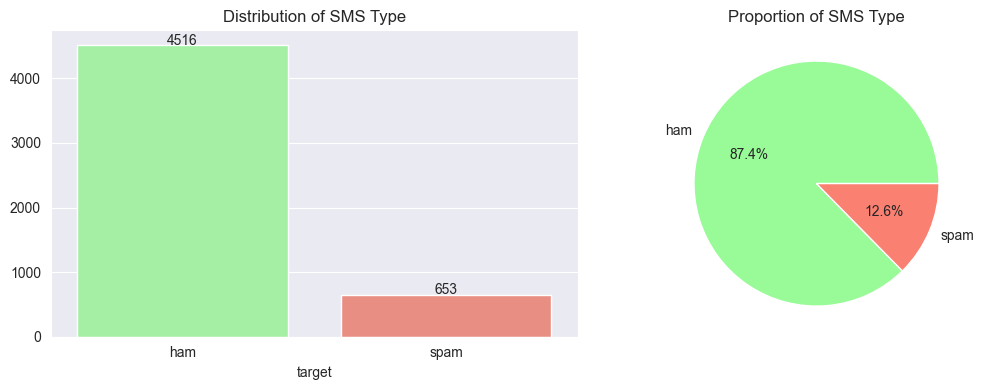

In [14]:
colors = {'ham': 'palegreen', 'spam': 'salmon'}

categories = df['target'].value_counts().index
values = df['target'].value_counts().values

fig, axs = plt.subplots(1, 2)

sns.barplot(x=categories, y=values, ax=axs[0], palette=colors.values(), legend=False, hue=categories)
axs[0].set_title('Distribution of SMS Type')

for i in range(len(categories)):
    axs[0].text(i, values[i] + 1, str(values[i]), ha='center')

axs[1].pie(values, labels=categories, autopct='%1.1f%%', colors=[colors[cat] for cat in categories])
axs[1].set_title('Proportion of SMS Type')

plt.tight_layout()
plt.show()

<center> <h3> Visualization of Message Content Through Word Clouds </h3> </center>

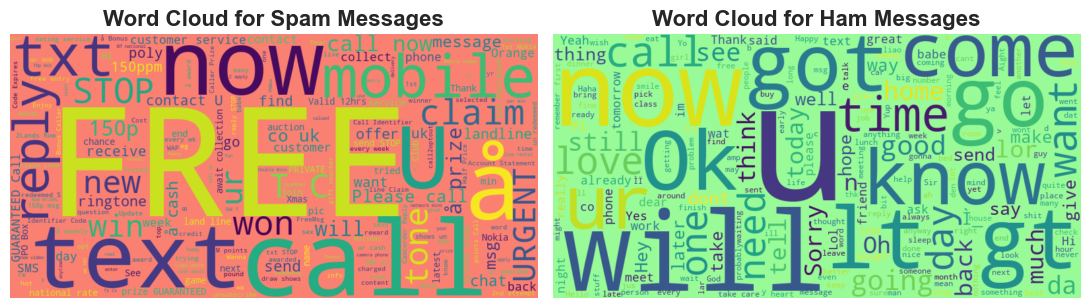

In [15]:
spam_text = ' '.join(df[df['target']=='spam']['text'].tolist())
ham_text = ' '.join(df[df['target']=='ham']['text'].tolist())

spam_wordcloud = WordCloud(width=800, height=400, background_color='salmon').generate(spam_text)
ham_wordcloud = WordCloud(width=800, height=400, background_color='palegreen').generate(ham_text)

plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axis('off')

plt.tight_layout()
plt.show()

<center> <h3> Analysis of Unique Words in SMS Messages </h3> </center>

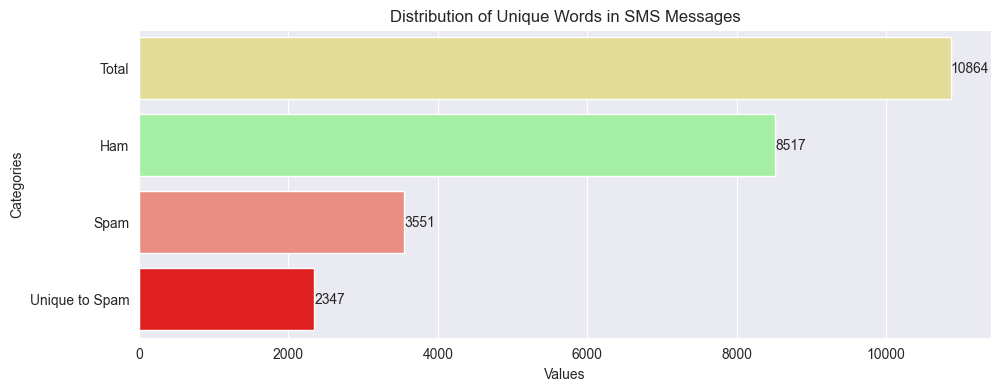

In [16]:
bar_color_mapping = {'Total': 'khaki', 'Ham': 'palegreen', 'Spam': 'salmon', 'Unique to Spam': 'red'}
bar_categories = ['Total', 'Ham', 'Spam', 'Unique to Spam']
bar_values = [
    sms_info.get_total_words(),
    sms_info.get_num_unique_words('ham'),
    sms_info.get_num_unique_words('spam'),
    len(sms_info.get_n_unique_most_words_only_in_spam(None))
]


sns.barplot(x=bar_values, y=bar_categories, palette=list(bar_color_mapping.values()), hue=bar_categories, orient='h')

for i in range(len(bar_categories)):
    plt.text(bar_values[i], i, str(bar_values[i]), va='center')

plt.title('Distribution of Unique Words in SMS Messages')
plt.xlabel('Values')
plt.ylabel('Categories')
plt.show()

<center> <h3> Analysis of Top 20 Unique Words Exclusive to Spam Messages </h3> </center>

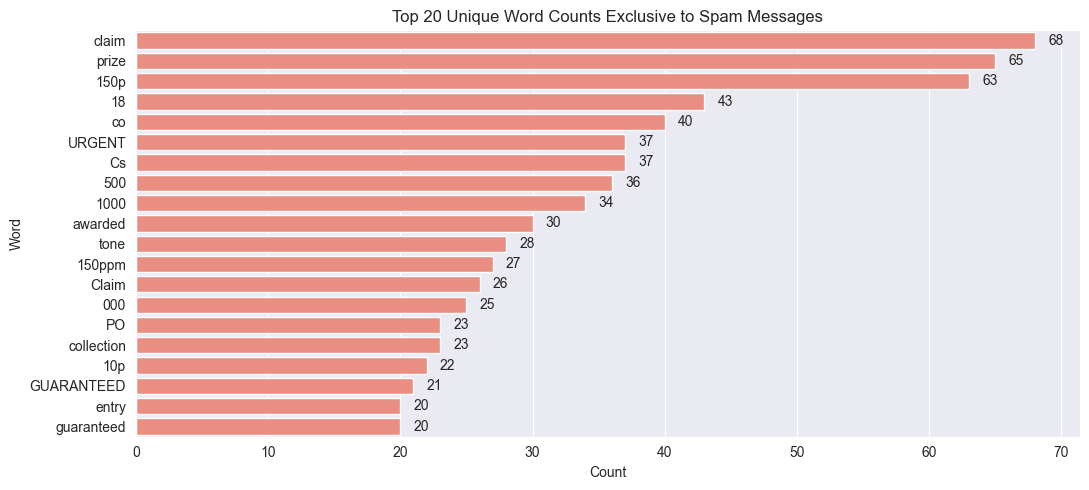

In [17]:
categories = list(sms_info.get_n_unique_most_words_only_in_spam(20).keys())
values = list(sms_info.get_n_unique_most_words_only_in_spam(20).values())

plt.figure(figsize=(11, 5)) 
ax = sns.barplot(x=values, y=categories, color='salmon')
ax.set_title('Top 20 Unique Word Counts Exclusive to Spam Messages')
ax.set_xlabel('Count')
ax.set_ylabel('Word')

for i, value in enumerate(values):
    ax.text(value + 1, i, str(value), ha='left', va='center')

plt.tight_layout()
plt.show()

<center> <h3> Visualization of Exclusive Spam Message Content Through Word Clouds </h3> </center>

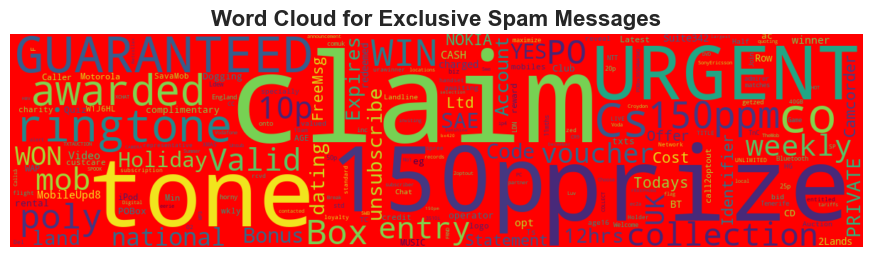

In [18]:
unique_words_freq = sms_info.get_n_unique_most_words_only_in_spam(None)

only_spam_text = ' '.join(key for key, value in unique_words_freq.items() for _ in range(value))

only_spam_wordcloud = WordCloud(width=1200, height=300, background_color='red', collocations=False).generate(only_spam_text)

plt.imshow(only_spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Exclusive Spam Messages', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axis('off')
plt.show()

<center> <h3> Analysis of Characters in Spam and Ham Messages </h3> </center>

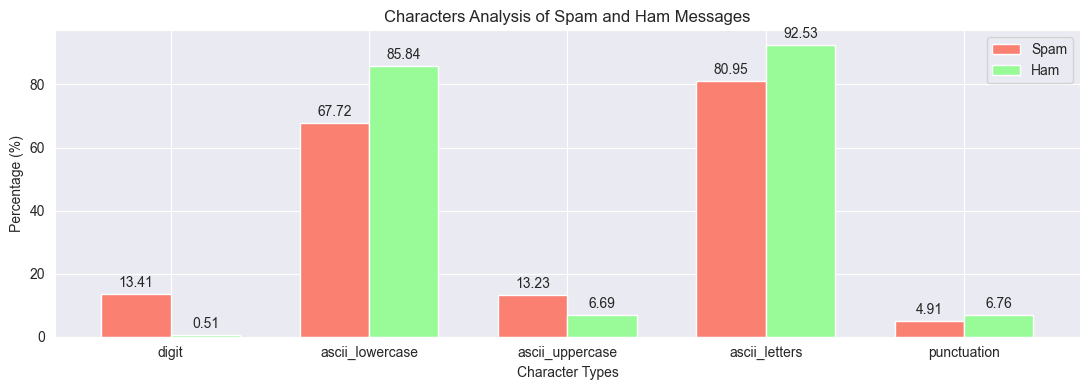

In [19]:
spam_data = sms_info.analyze_chars('spam')
ham_data = sms_info.analyze_chars('ham')

colors = {'ham': 'palegreen', 'spam': 'salmon'}

fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(spam_data))

spam_bars = ax.bar(index, spam_data.values(), bar_width, label='Spam', color=colors['spam'])

ham_bars = ax.bar([i + bar_width for i in index], ham_data.values(), bar_width, label='Ham', color=colors['ham'])

ax.set_xlabel('Character Types')
ax.set_ylabel('Percentage (%)')
ax.set_title('Characters Analysis of Spam and Ham Messages')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(spam_data.keys())
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(spam_bars)
add_labels(ham_bars)
plt.tight_layout()
plt.show()

<center> <h3> Analysis of Words in Spam and Ham Messages </h3> </center>

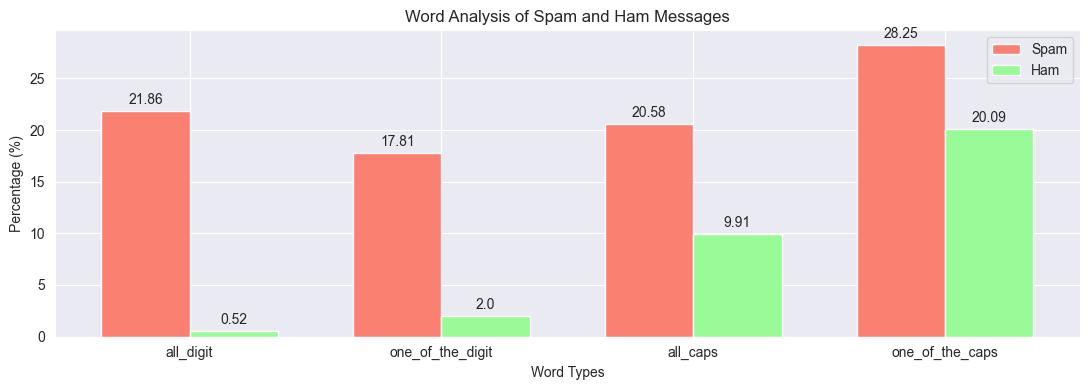

In [20]:
spam_data = sms_info.analyze_words('spam')
ham_data = sms_info.analyze_words('ham')

colors = {'ham': 'palegreen', 'spam': 'salmon'}

fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(spam_data))

spam_bars = ax.bar(index, spam_data.values(), bar_width, label='Spam', color=colors['spam'])

ham_bars = ax.bar([i + bar_width for i in index], ham_data.values(), bar_width, label='Ham', color=colors['ham'])

ax.set_xlabel('Word Types')
ax.set_ylabel('Percentage (%)')
ax.set_title('Word Analysis of Spam and Ham Messages')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(spam_data.keys())
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(spam_bars)
add_labels(ham_bars)
plt.tight_layout()
plt.show()

<center> <h2> Feature Engineering </h2> </center>

<center> <h3> Message Length </h3> </center>

In [21]:
df['message_length'] = df['text'].apply(len)

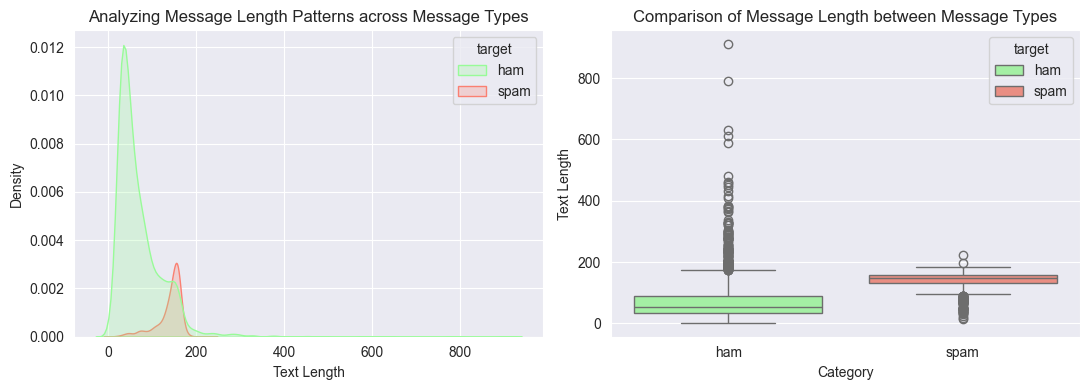

In [22]:
palette_colors = {'ham': 'palegreen', 'spam': 'salmon'}

fig, axs = plt.subplots(1, 2)

sns.kdeplot(data=df, x='message_length', hue='target', fill=True, palette=palette_colors, ax=axs[0], legend=True)
axs[0].set_title('Analyzing Message Length Patterns across Message Types')
axs[0].set_xlabel('Text Length')
axs[0].set_ylabel('Density')

sns.boxplot(data=df, x='target', y='message_length', hue='target', palette=palette_colors, ax=axs[1], legend=True)
axs[1].set_title('Comparison of Message Length between Message Types')
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Text Length')

plt.tight_layout()
plt.show()

<center> <h3> Number of Digits </h3> </center>

In [23]:
df['number_of_digits'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x.replace(' ','')))

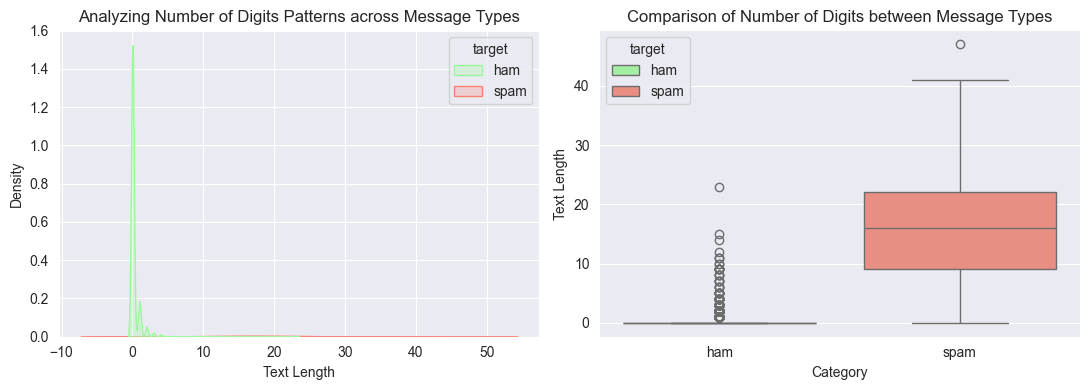

In [24]:
palette_colors = {'ham': 'palegreen', 'spam': 'salmon'}

fig, axs = plt.subplots(1, 2)

sns.kdeplot(data=df, x='number_of_digits', hue='target', fill=True, palette=palette_colors, ax=axs[0], legend=True)
axs[0].set_title('Analyzing Number of Digits Patterns across Message Types')
axs[0].set_xlabel('Text Length')
axs[0].set_ylabel('Density')

sns.boxplot(data=df, x='target', y='number_of_digits', hue='target', palette=palette_colors, ax=axs[1], legend=True)
axs[1].set_title('Comparison of Number of Digits between Message Types')
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Text Length')

plt.tight_layout()
plt.show()

<center> <h3> Number of Capital Words </h3> </center>

In [25]:
df['number_of_cap_words'] = df['text'].apply(lambda x: sum(c.isupper() for c in re.findall(r'\w+', x)))

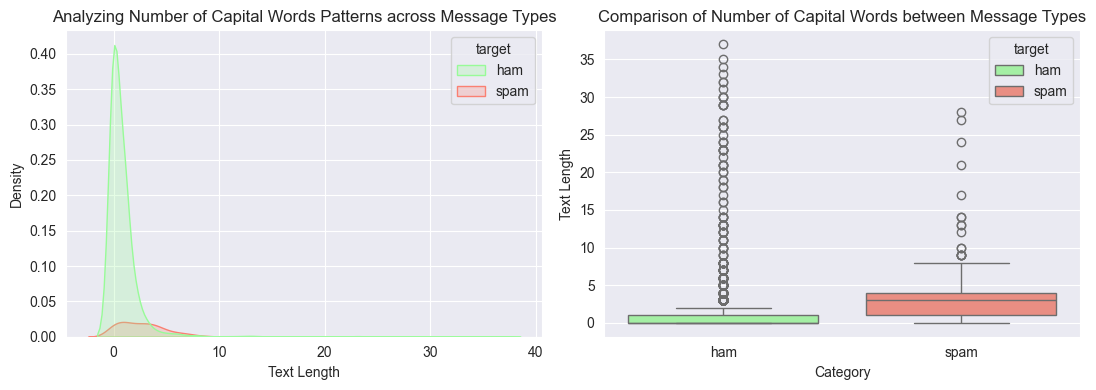

In [26]:
palette_colors = {'ham': 'palegreen', 'spam': 'salmon'}

fig, axs = plt.subplots(1, 2)

sns.kdeplot(data=df, x='number_of_cap_words', hue='target', fill=True, palette=palette_colors, ax=axs[0], legend=True)
axs[0].set_title('Analyzing Number of Capital Words Patterns across Message Types')
axs[0].set_xlabel('Text Length')
axs[0].set_ylabel('Density')

sns.boxplot(data=df, x='target', y='number_of_cap_words', hue='target', palette=palette_colors, ax=axs[1], legend=True)
axs[1].set_title('Comparison of Number of Capital Words between Message Types')
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Text Length')

plt.tight_layout()
plt.show()

<center> <h3> Contains URL </h3> </center>

In [27]:
def contains_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return 1 if re.search(url_pattern, text) else 0

In [28]:
df['contains_url'] = df['text'].apply(contains_url)

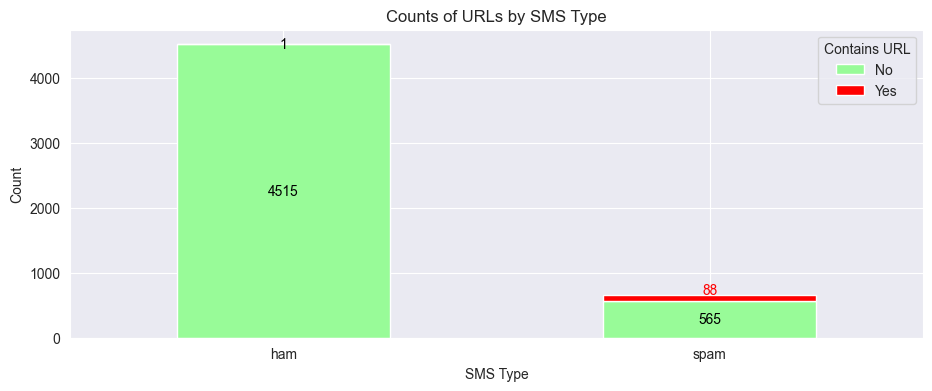

In [29]:
temp_df = df.groupby(['target', 'contains_url']).size().unstack()
temp_df.rename(columns={0: 'No', 1: 'Yes'}, inplace=True)
grouped = temp_df

colors = {'No': 'palegreen', 'Yes': 'red'}

ax = grouped.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped.columns])

plt.legend(title='Contains URL')

plt.xlabel('SMS Type')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Counts of URLs by SMS Type')

for p in ax.patches[:3]:
    if p.get_height() != 0:
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2., int(p.get_height()), 
                ha='center', va='center', color='black', fontsize=10)
        
for p in ax.patches[3:]:
    if p.get_height() != 0:
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() + 150/ 2., int(p.get_height()), 
                ha='center', va='center', color='red', fontsize=10)

plt.show()

In [30]:
df

,target,text,message_length,number_of_digits,number_of_cap_words,contains_url
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,25,4,0
3,ham,U dun say so early hor... U c already then say...,49,0,2,0
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,0,1,0
...,...,...,...,...,...,...
5164,spam,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",161,21,3,0
5165,ham,Will Ì_ b going to esplanade fr home?,37,0,1,0
5166,ham,"Pity, * was in mood for that. So...any other suggestions?",57,0,0,0
5167,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,125,0,1,0


<center> <h2> Rule Based SMS Spam Detection </h2> </center>

In [31]:
spam_word_set = set(sms_info.get_n_unique_most_words_only_in_spam(None).keys())
def get_sms_type(sms):
    sms_word_set = set(re.findall(r'\w+', sms))
    is_spam_word_match = bool(sms_word_set & spam_word_set)
    if is_spam_word_match:
        return 'spam'
    else:
        return 'ham'

In [32]:
def plot_confusion_matrix(actual_labels, predicted_labels):
    matrix = confusion_matrix(actual_labels, predicted_labels)
    categories = ['ham', 'spam']
    labels = ['True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)', 'True Positive (TP)']
    values = np.array([[matrix[0, 0], matrix[0, 1]],
                       [matrix[1, 0], matrix[1, 1]]])
    plt.figure(figsize=(6, 4))
    sns.heatmap(values, annot=True, fmt="d", cmap="Greys", xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [33]:
actual_labels = df['target'].tolist()
predicted_labels = df['text'].apply(get_sms_type).tolist()

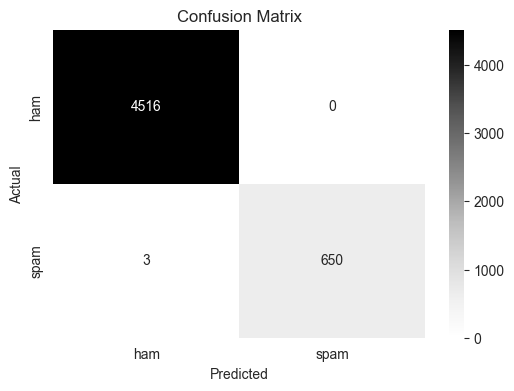

In [34]:
plot_confusion_matrix(actual_labels, predicted_labels)

<center> <h2> Train Test Split </h2> </center>

In [35]:
X = df['text'].values
y = df['target'].map({'ham':-1, 'spam': 1}).values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [37]:
print(f"Total Number of Messages in Complete Dataset: {X.shape[0]}")
print(f"Total Number of Messages in Train Dataset: {X_train.shape[0]}")
print(f"Total Number of Messages in Test Dataset: {X_test.shape[0]}")

Total Number of Messages in Complete Dataset: 5169
Total Number of Messages in Train Dataset: 4135
Total Number of Messages in Test Dataset: 1034


In [38]:
print(f"Spam Distribution in Complete Dataset: {round(Counter(y)[1]/((Counter(y)[1]+Counter(y)[-1]))*100, 2)}%")
print(f"Spam Distribution in Train Dataset: {round(Counter(y_train)[1]/((Counter(y_train)[1]+Counter(y_train)[-1]))*100, 2)}%")
print(f"Spam Distribution in Test Dataset: {round(Counter(y_test)[1]/((Counter(y_test)[1]+Counter(y_test)[-1]))*100, 2)}%")

Spam Distribution in Complete Dataset: 12.63%
Spam Distribution in Train Dataset: 12.53%
Spam Distribution in Test Dataset: 13.06%


<center> <h2> Baseline Machine Learning Model </h2> </center>

In [39]:
from sklearn.dummy import DummyClassifier

In [40]:
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

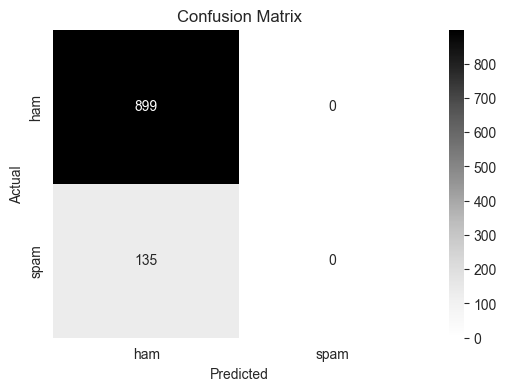

In [41]:
plot_confusion_matrix(y_test, y_pred)

In [42]:
balanced_accuracy_score(y_test, y_pred)

0.5

In [43]:
accuracy_score(y_test, y_pred)

0.8694390715667312

In [44]:
precision_score(y_test, y_pred, pos_label=1, zero_division=0)

0.0

In [45]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

          -1       0.87      1.00      0.93       899
           1       0.00      0.00      0.00       135

    accuracy                           0.87      1034
   macro avg       0.43      0.50      0.47      1034
weighted avg       0.76      0.87      0.81      1034



<center> <h2> Experiments With Different ML Models </h2> </center>

In [46]:
class TextLengthTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([len(x) for x in X]).reshape(-1, 1)

class DigitCountTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([sum(c.isdigit() for c in x.replace(' ','')) for x in X]).reshape(-1, 1)

class UppercaseCountTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([sum(c.isupper() for c in re.findall(r'\w+', x)) for x in X]).reshape(-1, 1)

class URLPresenceTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([1 if re.search(re.compile(r'https?://\S+|www\.\S+'), x) else 0 for x in X]).reshape(-1, 1)

class TextCleanerWithStemming(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._get_clean_text_with_stemming(text) for text in X])
    
    def _get_clean_text_with_stemming(self, text):
        cleaned_text = re.sub(r'[^a-zA-Z ]', ' ', text)
        tokens = word_tokenize(cleaned_text)
        stemmed_tokens = [self.stemmer.stem(word) for word in tokens if len(word) > 1]
        return ' '.join(stemmed_tokens)

In [47]:
text_to_vectors = Pipeline([
    ('text_cleaning', TextCleanerWithStemming()),
    ('vectorizer', CountVectorizer(
        stop_words='english',
        token_pattern=r'\w+',
    )),
])

text_to_features = FeatureUnion([
    ('text_to_vectors', text_to_vectors),
    ('text_length', TextLengthTransformer()),
    ('digit_count', DigitCountTransformer()),
    ('uppercase_count', UppercaseCountTransformer()),
    ('url_presence', URLPresenceTransformer())
])

pipeline = Pipeline([
    ('features', text_to_features),
    ('clf', MultinomialNB(alpha=0.1)),
])

Precision Score: 0.9694656488549618
Balanced Accuracy Score: 0.9681456762658098
Accuracy Score: 0.988394584139265


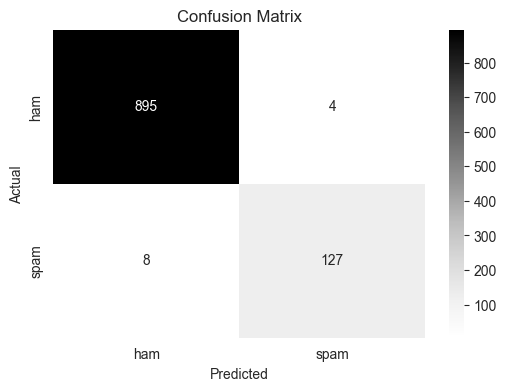

In [48]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Precision Score:', precision_score(y_test, y_pred, pos_label=1))
print('Balanced Accuracy Score:', balanced_accuracy_score(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)

Precision Score: 0.974903474903475
Balanced Accuracy Score: 0.9856546680572116
Accuracy Score: 0.9937122128174123


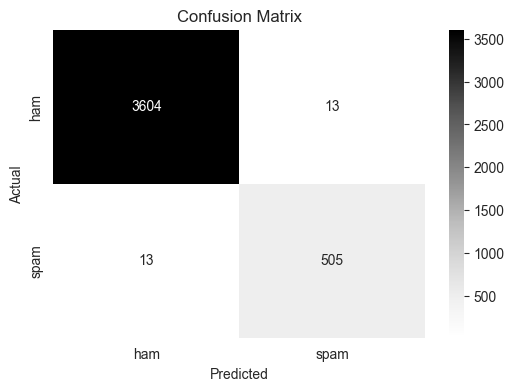

In [49]:
y_pred = pipeline.predict(X_train)

print('Precision Score:', precision_score(y_train, y_pred, pos_label=1))
print('Balanced Accuracy Score:', balanced_accuracy_score(y_train, y_pred))
print('Accuracy Score:', accuracy_score(y_train, y_pred))

plot_confusion_matrix(y_train, y_pred)

5387

In [50]:
import pickle
with open('text_classification_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
with open('text_classification_pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

test = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

predictions = loaded_pipeline.predict(test)

print(predictions)

[-1  1]


In [55]:
import nltk
import sklearn

In [56]:
print("NLTK version:", nltk.__version__)
print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)

NLTK version: 3.7
NumPy version: 1.23.5
Scikit-learn version: 1.2.1


In [57]:
loaded_pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_to_vectors',
                                                 Pipeline(steps=[('text_cleaning',
                                                                  TextCleanerWithStemming()),
                                                                 ('vectorizer',
                                                                  CountVectorizer(stop_words='english',
                                                                                  token_pattern='\\w+'))])),
                                                ('text_length',
                                                 TextLengthTransformer()),
                                                ('digit_count',
                                                 DigitCountTransformer()),
                                                ('uppercase_count',
                                                 UppercaseCountTransformer()),
                                                ('url_presence',
                                                 URLPresenceTransformer())])),
                ('clf', MultinomialNB(alpha=0.1))])